<table style="width: 100%; border-collapse: collapse;" border="0">
<tr>
<td><b>Created:</b> Monday 30 January 2017</td>
    <td style=\"text-align: right;\"><b> Original source: </b><a href=\"https://www.github.com/rhyswhitley/fire_limitation\">github.com/rhyswhitley/fire_limitation</td>
</tr>
<tr>
<td><b>Modified:</b> Friday 16 March 2018</td>
    <td style=\"text-align: right;\"><b> Current source: </b><a href=\"https://github.com/douglask3/UKESM_albedo_tile_optimization\">github.com/douglask3/UKESM_albedo_tile_optimization</td>
</tr>
</table>
<div>
<center>
<font face="Times">
<br>
<h1>Quantifying the uncertainity of UM tile & bare soil albedo using Bayesian inference</h1>
<br>
<br>
Douglas Kelley<sup>1,* </sup>, 
Rich Ellis<sup>1 </sup>, 
Alistair Sellar<sup>2 </sup>,
Rhys Whitley<sup>3 </sup>
<br>
<br>
<br>
<sup>1 </sup>Centre for Ecology and Hydrology, Maclean Building, Crowmarsh Gifford, Wallingford, Oxfordshire, United Kingdom
<br>
<sup>2 </sup>Met Office United Kingdom, Exeter, United Kingdom
<br>
<sup>3 </sup>Natural Perils Pricing, Commercial & Consumer Portfolio & Pricing, Suncorp Group, Sydney, Australia
<br>
<br>
<h3>Summary</h3>
<hr>
<p> 
Optimizing albedo parameters for tile-albedo schemes in UKESM, including quantifying parameter uncertainty, using Bayesian Inference
</p>
<br>
<br>
<br>
<i>Python code and calculations below</i>
<br>
</font>
</center>
<hr>
</div>

### Load libraries

In [ ]:
%load_ext autoreload
%autoreload

import sys
sys.path.append('../')

# data munging and analytical libraries 
import re
import os
import numpy as np
import pandas as pd
import iris

# optimization libraries
import pymc3 as pm3 
from pymc3.backends import SQLite
from scipy import optimize
from theano import tensor as tt

# graphical libraries
import matplotlib.pyplot as plt
import numpy.ma as ma
%matplotlib inline
import cartopy.crs as ccrs
from   libs.plot_maps    import *
from   libs.ExtractLocation import *

albedo_levels = [0, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.6, 1.0]
albedo_diff_levels = [-0.15, -0.1, -0.05, -0.01, 0.01, 0.05, 0.1, 0.15]

def plot_month_data(cubes, cmap, levels):
    plot_cubes_map(cubes, 'JFMAMJJASOND', cmap, levels, ny = 4,  figXscale = 1.5, figYscale = .5)
    
def plot_cover_data(cubes, cmap = 'brewer_Greens_09', levels = [0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.8]):
    plot_cubes_map(cubes, pft_name, cmap, levels, ny = 5, 
                   figXscale = 2.5, figYscale = 0.3)

# setup nice plotting
plt.style.use('ggplot')
%matplotlib inline

sample_pc = 10
param_outhpath = '../data/albedomodel_new_trace2.csv'
trace_db_file      = '../data/model.db'

## 0 Import and clean data

Set the directory path and look for all files that correspond to the model drivers and target.

In [2]:
data_dir = '/users/global/doukel/ukesm_prj/JULES_UKESM_albedo/data/'

Files = ["qrclim.land",
         "qrparm_frac_27_tile_orca1_cci.anc",
         "qrparm_func_orca1_13_tile.anc",
         "qrparm.soil"]

unknown_stash = {"m01s00i216": "FRACTIONS OF SURFACE TYPES",
                 "m01s00i207": "UNFILTERED OROGRAPHY",
                 "m01s00i008": "SOIL BULK DENSITY   KG/M3"}


data = list()
for i in Files:
    cubes = iris.load(data_dir + i)
    #cubes = ExtractLocation(cubes, 360-90, 360-30, -60, 15).cubes
    for i in cubes: data.append(i)

for code in unknown_stash:
    for cube in data:
        if cube.attributes['STASH'] == code: cube.long_name = unknown_stash[code]

Select only variables we need for tiles we will optimize for

In [3]:
def select_data(name, transferMask = None):
    for i in data:
        if i.name() == name: out =  i
    if transferMask is not None : out = transfer_mask(out, transferMask)
        
    return out
        
def select_pseudo_level(cube, codes):
    code = cube.coord('pseudo_level').points
    ids = [np.where(code == id)[0][0] for id in  codes]
    out = cube[ids]
        
    return out

def transfer_mask(cube, cmask):
    mask0 = cmask.data.mask
    mask = mask0
    
    if len(cube.shape) > 2:
        nlevs = len(cube.data)
        for i in range(nlevs - 1): mask = np.append(mask, mask0)
        mask = np.reshape(mask, newshape = np.append(nlevs, mask0.shape))
    else:
        mask = np.reshape(mask, newshape = mask0.shape)
    cube.data = ma.array(cube.data, mask = mask)
    return cube

pft_name    = ['BDT', 'BET-Tr', 'BET-te', 'NDT', 'NET', 'ESh', 'DSh', 'C3G', 'C4G']
pft_code    = [101  , 102     , 103     , 201  , 202  , 501 , 502   , 3    , 4    ]

tile_name   =          ['Urban', 'Lake', 'Ice']
tile_code   = np.array([6      , 7     , 9    ])

bare_name   = ['Bare Soil']
bare_code   = [8          ]

albedo_obs  = select_data('surface_diffuse_albedo_assuming_no_snow')
bulk_density= select_data("SOIL BULK DENSITY   KG/M3")
cover       = select_data('FRACTIONS OF SURFACE TYPES', transferMask = bulk_density)

bulk_density = transfer_mask(bulk_density, albedo_obs[0])
albedo_obs   = transfer_mask(albedo_obs, bulk_density)
cover        = transfer_mask(cover, albedo_obs[0])

LAI         = select_data('leaf_area_index', transferMask = cover[0:12])
albedo_bare = select_data('soil_albedo', transferMask = bulk_density)
albedo_obs  = select_data('surface_diffuse_albedo_assuming_no_snow', transferMask = bulk_density)

bulk_density             = select_data("SOIL BULK DENSITY   KG/M3", transferMask = bulk_density)
orography                = select_data("UNFILTERED OROGRAPHY", transferMask = bulk_density)
carbon                   = select_data("soil_carbon_content", transferMask = bulk_density)
hyd_cond                 = select_data("soil_hydraulic_conductivity_at_saturation", transferMask = bulk_density)
porosity                 = select_data("soil_porosity", transferMask = bulk_density)
saturation_suction       = select_data("soil_suction_at_saturation", transferMask = bulk_density)
thermal_capacity         = select_data("soil_thermal_capacity", transferMask = bulk_density)
thermal_conductivity     = select_data("soil_thermal_conductivity", transferMask = bulk_density)
frac_critical_point_condensed_water = select_data("volume_fraction_of_condensed_water_in_soil_at_critical_point", transferMask = bulk_density)
cond_wilting_point_water = select_data("volume_fraction_of_condensed_water_in_soil_at_wilting_point", transferMask = bulk_density)

    
cover_pft   = select_pseudo_level(cover,  pft_code)
cover_veg   = cover_pft.collapsed('pseudo_level', iris.analysis.SUM)
cover_tile  = select_pseudo_level(cover, tile_code)
cover_bare  = select_pseudo_level(cover, bare_code)
LAI         = select_pseudo_level(LAI  , pft_code)

/users/global/doukel/anaconda3/lib/python3.6/site-packages/iris/coords.py:1162: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  if np.issubdtype(self.dtype, np.str):
/users/global/doukel/anaconda3/lib/python3.6/site-packages/iris/coords.py:1191: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'pseudo_level'.
  warnings.warn(msg.format(self.name()))


/users/global/doukel/anaconda3/lib/python3.6/site-packages/iris/coords.py:975: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/users/global/doukel/anaconda3/lib/python3.6/site-packages/iris/coords.py:975: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))


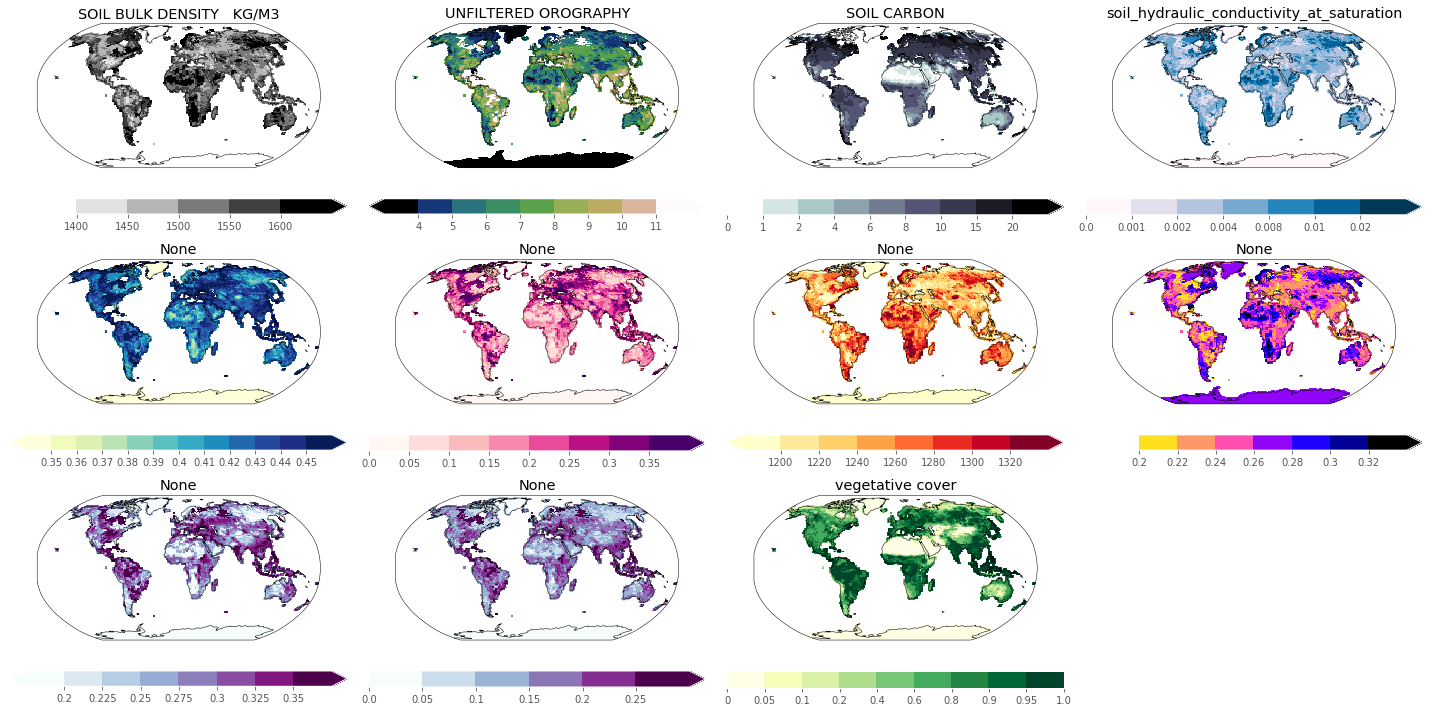

In [4]:
plt.figure(figsize = (20, 10))
plot_lonely_cube(bulk_density, 3, 4, 1, cmap = 'Greys', levels = [1400, 1450, 1500, 1550, 1600], extend = 'both')
plot_lonely_cube(orography, 3, 4, 2, cmap = 'gist_earth', levels = [4,5,6,7,8,9,10, 11], extend = 'both')
carbon.long_name = 'SOIL CARBON'
plot_lonely_cube(carbon, 3, 4, 3, cmap = 'bone_r', levels = [0, 1, 2, 4, 6, 8, 10, 15, 20],extend = 'max')
hyd_cond.long_name = "soil_hydraulic_conductivity_at_saturation"
plot_lonely_cube(hyd_cond, 3, 4, 4, cmap = 'PuBu', levels = [0.0, 0.001, 0.002, 0.004, 0.008, 0.01, 0.02], extend = 'max')
plot_lonely_cube(porosity, 3, 4, 5, cmap = 'YlGnBu', levels = [0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45], extend = 'both')
plot_lonely_cube(saturation_suction, 3, 4, 6, cmap = 'RdPu', levels = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35], extend = 'max')
plot_lonely_cube(thermal_capacity / 1000.0, 3, 4, 7,cmap = 'YlOrRd', levels = [1200, 1220, 1240, 1260, 1280, 1300, 1320], extend = 'both')
plot_lonely_cube(thermal_conductivity, 3, 4, 8,cmap = 'gnuplot2_r', levels = [0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32], extend = 'both')
plot_lonely_cube(frac_critical_point_condensed_water, 3, 4, 9,cmap = 'BuPu', levels = [0.2, 0.225, 0.25, 0.275, 0.3, 0.325, 0.35], extend = 'both')
plot_lonely_cube(cond_wilting_point_water, 3, 4, 10,cmap = 'BuPu', levels = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25], extend = 'max')
cover_veg.long_name = 'vegetative cover'
plot_lonely_cube(cover_veg, 3, 4, 11, cmap = 'YlGn', levels = [0, 0.05, 0.1, 0.2, 0.4,  0.6, 0.8, 0.9, 0.95, 1.0])

##### 1. Simple version

### 1.1 Model description
There are two options to determine the surface albedo($\alpha$). We start by optimizing the simplest option, described in Best et al. 2011. A vegetative tile albedo ($\alpha_{pft}$) is calculated from the PFTs leaf albedo ($\alpha_{\infty}$) and the underlying soil albedo ($\alpha_b$). The amount of light that makes it to the ground, and therefore the balance of the conbrtibution of $\alpha_{\infty}$ to $\alpha_b$, follows a simple extiction curve through the canopy based on the PFTs Leaf Area Index ($LAI$):

\begin{eqnarray}
    \alpha_{pft} &=& \alpha_b \cdot e^{-k \cdot LAI}  + \alpha_{\infty} \cdot ( 1 - e^{-k \cdot LAI} )
\end{eqnarray}
Where $-k$ is a $PFT$ specific extinction rate parameter.

None vegetated tiles have a single albedo value ($\alpha_{tile}$). The albedo of a cell is the weighed albedo of all tiles:

\begin{eqnarray}
    \alpha = \sum_{pft} C_{pft} \cdot \alpha_{pft}(\alpha_{b}, \alpha_{\infty, pft}, k_{pft}, LAI_{pft}) +
             \sum_{tile} C_{tile} \cdot \alpha_{tile} + C_{b} \cdot \alpha_{b}
\end{eqnarray}

where $C_i$ is the fractional cover of PFT, non vegetated and bare soil tiles.

We will optimized over the 9 PFTs desciebed in ..., 3 non-vegetated tiles from ... and bare soil. Bare soil will need a value per grid cell, but to keep things simple to start with, we will use one global bare soil value. We will therefore be optimizing 18 vegetation paramters ($k$ and $alpha_{\infty}$ for each PFT), 3 non-vegetated paramters ($\alpha_{tile}$ for each tile) and $\alpha_b$. 22 paramters in total.
 

### 1.2 Model definition

Could possibly contain this in a class object, but I'm not sure theano can instantiate the object to be used by the GPU. If I've made absolutely no sense just then, then I would leave the following as is.

In [ ]:
def squish(x, nc):
    return ((nc - 1.0) * x + 0.5)/nc

def logit(x, FUN = None, nc = 100):

    x = squish(x, nc)
    x = x / (1.0 - x)

    try:
        x = tt.log(x)
    except:
        x= np.log(x)
    return x

def sigmoid(x):
    try:
        x = tt.exp(-x)
    except:
        x = np.exp(-x)
    return 1.0/(1.0 + x)

def logistic(x, x0, k):
    try:
        x = k*(x - x0)
    except:
        browser()
    return sigmoid(x)

In [ ]:
from pdb import set_trace as browser
def pft_albedo(albedo_bare, albedo_inf, k, LAI):
    
    if k == -999:
        extinct = 0
    else:
        try:
            extinct = tt.exp(-k * LAI)
        except:
            extinct = np.exp(-k * LAI)
    albedo = albedo_bare * extinct + albedo_inf * (1 - extinct)
    return albedo
    
def cell_albedo_prescibedSoil(cover_pft, LAI, cover_tile, cover_bare, albedo_bare, albedo_inf, k, albedo_tile, 
                nPft = None, nTile = None):
    if nPft  is None: nPft  = len(cover_pft)
    if nTile is None: nTile = len(cover_tile)
        
    pft_albedos = [pft_albedo(albedo_bare, albedo_inf[i], k[i], LAI[i]) for i in range(nPft)]  
    
    veg = [cover_pft[i] *  pft_albedos[i] for i in range(nPft)]  
    non = [cover_tile[i] * albedo_tile[i] for i in range(nTile)] 
        
    albedo = np.sum(veg + non + [cover_bare * albedo_bare])
    return albedo

def soil_albedo(cover_veg, bulk_density_in, orography_in, carbon_in, hyd_cond_in, porosity, 
                saturation_suction, thermal_capacity_in,
                thermal_conductivity, frac_critical_point_condensed_water, cond_wilting_point_water,
                vCV, vBD, vO, vC, vH, vP, vSS, vTCap, vTCon, vCPW, vWPW,
                sa_0, slope_sa):
    
    bulk_density = bulk_density_in.copy()
    orography = orography_in.copy()
    carbon = carbon_in.copy()
    hyd_cond = hyd_cond_in.copy()
    thermal_capacity = thermal_capacity_in.copy()
    
    bulk_density /= 1000.0
    orography /= 10.0
    carbon /= 10.0
    hyd_cond *=10.0
    thermal_capacity /= 1000000.0
    
    out = vCV * cover_veg + vBD*bulk_density + vO*orography + vC*carbon + vH*hyd_cond + vP*porosity + vSS*saturation_suction + \
             vTCap*thermal_capacity + vTCon*thermal_conductivity + \
             vCPW*frac_critical_point_condensed_water + vWPW*cond_wilting_point_water
    
    out = logistic(out, sa_0, slope_sa)
    
    return out

    
def cell_albedo(cover_pft, LAI, cover_tile, cover_bare, albedo_inf, k, albedo_tile, 
                nPft = None, nTile = None, *args, **kw):
    
    albedo_bare = soil_albedo(*args, **kw)
    
    albedo = cell_albedo_prescibedSoil(cover_pft, LAI, cover_tile, cover_bare, albedo_bare,
                                       albedo_inf, k, albedo_tile, 
                                       nPft, nTile)
    return albedo



def nosoil_cover(cover_pft, LAI, k, nPft = None):
    if nPft  is None: nPft  = len(cover_pft)
    
    def extinct_cover(cover, lai, ki):
        try:
            cov = (cover * (1 - tt.exp(-ki * lai)))
        except:
            cov = (cover * (1 - np.exp(-ki * lai)))
        return cov
    
    return np.array([extinct_cover(cover_pft[i], LAI[i], k[i]) for i in range(nPft)])
    

def nosoil_albedo(cover_pft, LAI, cover_tile, albedo_inf, k, albedo_tile, nPft = None, nTile = None, 
                  normalise = False, *args, **kw):
    
    if nPft  is None: nPft  = len(cover_pft)
    if nTile is None: nTile = len(cover_tile)
    
    cover_pft = nosoil_cover(cover_pft, LAI, k, nPft)
    k = np.repeat(-999, nPft) 
        
    albedo = cell_albedo_prescibedSoil(cover_pft, LAI, cover_tile, 0.0, 0.5, albedo_inf, k, albedo_tile, nPft, nTile, *args, **kw)
    
    if normalise: albedo = albedo/(np.sum(cover_pft,0) + np.sum(cover_tile,0))
    return(albedo)

### 1.3 Old configuration
Paramters are taken from UKESM1

In [ ]:
#             'BDT', 'BET-Tr', 'BET-te', 'NDT', 'NET', 'ESh', 'DSh', 'C3G', 'C4G'
albedo_inf  = [0.1 , 0.1     , 0.1     , 0.1  , 0.1  , 0.2  , 0.2  , 0.2  , 0.2 ]
k           = [0.5 , 0.5     , 0.5     , 0.5  , 0.5  , 0.5  , 0.5  , 0.5  , 0.5 ]

#             'Urban', 'Lake', 'Ice'
albedo_tile = np.array([0.18  , 0.06  , 0.75])

In [ ]:
albedo = albedo_obs.copy()
albedo.data = cell_albedo_prescibedSoil(cover_pft.data, LAI.data, cover_tile.data, cover_bare.data, albedo_bare.data, 
                          albedo_inf, k, albedo_tile)



In [ ]:
def plot_sim_albedo(albedo, comp_albedo = albedo_obs):    
    plot_month_data(albedo, 'copper', albedo_levels)
    plot_month_data(comp_albedo, 'copper', albedo_levels)

    albedo_dif = albedo - comp_albedo
    plot_month_data(albedo_dif, 'PuOr', albedo_diff_levels)
    
plot_sim_albedo(albedo)

In [ ]:
albedo_ns = albedo_obs.copy()
albedo_ns.data = nosoil_albedo(cover_pft.data, LAI.data, cover_tile.data, albedo_inf, k, albedo_tile, normalise = True)
#albedo_ns.data = sigmoid(albedo_ns.data)


plot_month_data(albedo_ns, 'copper', albedo_levels)

## 1.4 Baysian framework

A simple explanation of Baye's law is:

\begin{equation}
    P(\beta|X) \propto P(\beta)\cdot P(X|\beta)
\end{equation}

where $X$ is our data (observations of some arbitrary system), and $\beta$ our set of unexplained parameters that describe the reponse of our _proposed understanding_ of this system as it varies with $X$.

### 1.4.1 Prior definitions
Most paramaters have definite physical bounds (i.e, albedo is always between 0 and 1). Beyond that, I have no idea what the uncertainty on the hyper parameters should look like, so I've paramters with a minimum and maximum bound with a uniform prbability districution (pd), and for $k$ - a continuous paramter bounded by 0 - a $\chi^2$ pd:

\begin{eqnarray}
    P(\beta) &=& \prod_{i=1}^{pft}P(k_i)\prod_{i=1}^{pft}P(\alpha_{\infty, i}) \prod_{i=1}^{tile}P(\alpha_{i}) \cdot P(\alpha_b) P(\sigma) \\[1.5em]
    P(\alpha_i) &=& \mathcal{U}(0.0, 1.0) \\[1.5em]
    P(k) &=& {\chi^2}(1) \\[1em]
    P(\sigma) &=& \mathcal{N}(0, 1) \\[1em]
\end{eqnarray}

Where $\sigma$ is our model error. I'm not totally sure about the maths above being right, but it's just to show that _full_ prior is normal. Important, because we'll also describe the error (likelihood) as normal, such that the posterior is therefore normal (conjugate); i.e. $\mathcal{N}\times\mathcal{N}=\mathcal{N}$ (expansion happens in the mean of the exponent). 


### 1.5 Single value soil albedo

To start with, we will show how to use pymc3 to take advantage of the Baysian framework by infering a probability distributuon of the albedo models parameters, but assuming a constant value for bare soil albedo.

#### 1.5.1 Prior definition
And with that, back to the code.., `pymc3` is quite funky in that it allows me to create an empty `Model()` object and just add things to it as I need them using a `with` statement. I've called our Bayesian model `albedo_error` as that is what we are trying to Quantify.

In [ ]:
with pm3.Model() as albedo_error:
    
# first for the albedos (the shape paramter at the end state how many I want - 9 PFTs and 3 tiles)
    nPft  = 9
    nTile = 3
    albedo_inf  = pm3.Uniform   ('albedo_inf' , 0.0, 1.0, shape = nPft )
    albedo_tile = pm3.Uniform   ('albedo_tile', 0.0, 1.0, shape = nTile)

# Now the extiction coefficent, one for each pft
    k           = pm3.Exponential('k'          , 1.0     , shape = nPft )
    
    vs          = pm3.Normal('vs', 0.0, 2.0, shape = 11)
    
    sa_0        = pm3.Normal('sa_0', 0.0, 5.0)
    slope_sa        = pm3.Exponential('slope_sa', 5.0)

        
# describe the standard deviation in the error term
    sigma = pm3.HalfNormal('sigma', sd=1)
    
    

We're going to need some data in a slightly more pm3 friendly format in a sec, so here we flatten our model data and compress out the mask so we're left with just numbers:

In [ ]:
def compress_cube(cube_in, d2 = False, sample = None):
    cube = cube_in.copy()
    if d2:
        out = cube.data.compressed()
        if sample is not None: out = out[sample]
    else:
        out = np.array([cube.data[i].compressed() for i in range(len(cube.data))])
        if sample is not None: out = out[:,sample]
    return out

albedo_obs_c = compress_cube(albedo_obs)
ncells = albedo_obs_c.shape[1]
index = np.random.choice(range(ncells), size=np.int(ncells * sample_pc/100.0), replace=False)

In [ ]:

albedo_obs_c = compress_cube(albedo_obs, sample = index)
cover_pft_c  = compress_cube(cover_pft, sample = index)
cover_tile_c = compress_cube(cover_tile, sample = index)
cover_bare_c = compress_cube(cover_bare, sample = index)


cover_veg_c             = compress_cube(cover_veg, True, sample = index)
bulk_density_c         = compress_cube(bulk_density, True, sample = index) 
orography_c            = compress_cube(orography, True, sample = index) 
carbon_c               = compress_cube(carbon, True, sample = index) 
hyd_cond_c             = compress_cube(hyd_cond, True, sample = index) 
porosity_c             = compress_cube(porosity, True, sample = index)
saturation_suction_c   = compress_cube(saturation_suction, True, sample = index)
thermal_capacity_c     = compress_cube(thermal_capacity, True, sample = index)
thermal_conductivity_c = compress_cube(thermal_conductivity, True, sample = index) 
frac_critical_point_condensed_water_c = compress_cube(frac_critical_point_condensed_water, True, sample = index) 
cond_wilting_point_water_c = compress_cube(cond_wilting_point_water, True, sample = index)

LAI_c = np.array([compress_cube(LAI[i], sample = index) for i in range(len(LAI.data))])




#### 1.5.2 Likelihood definition

For the sake of simplicity (and because I don't really know any better), we define the model error as normally distributed (i.i.d.) although it most likely isn't. We could make this more complicated later by defining the error as heteroscedastic, but I wouldn't bother with that until we have some idea of the convergence. We're describing the error (observations minus model predictions) as follows:

\begin{eqnarray}
    P(X|\beta) &=& \mathcal{N}(X_i, \sigma) \\[1em]
    \mathcal{N}(F_{burn}, \sigma) &=& \frac{N}{\sigma\sqrt{2\pi}}\exp\left\{\sum_{i=1}^{N}\left(\frac{y_i - x_i}{\sigma_i}\right)^2\right\}
\end{eqnarray}

where $x_i$ is our model prediction and $y_i$ is a set of observations we're attempting to optimise on. Below is the code that describes the above:

In [ ]:
cover_pft_c[1]

In [ ]:
with albedo_error:
    
    prediction = cell_albedo(cover_pft_c, LAI_c, cover_tile_c, cover_bare_c, albedo_inf, k, albedo_tile, 
                nPft, nTile, cover_veg_c, bulk_density_c, orography_c, carbon_c, hyd_cond_c, porosity_c,
                             saturation_suction_c, thermal_capacity_c,
                thermal_conductivity_c, frac_critical_point_condensed_water_c, cond_wilting_point_water_c,
                vs[0], vs[1], vs[2], vs[3], vs[4], vs[5], vs[6], vs[7], vs[8], vs[9],v[10],
                sa_0, slope_sa)
    
    error = pm3.Normal('error', mu=prediction , sd=sigma, observed=albedo_obs_c )
   

#### 1.5.3 Posterior sampling

Because it is nigh impossible to determine the posterior solution analytically we will instead sample the information space to **infer** the posterior solutions for each of the model parameters. In this case we are using a Metropolis-Hasting step MCMC.

I've tried using No-U-Turn (NUTS) sampling (which is the new kid on the block), but there are issues with it's current implementation in pymc3 (see github repo issues). Can use it once problems are ironed out - but TBH it doesn't matter if we're getting a reasonable convergence.

In [ ]:
niterations = 40000

with albedo_error:
    
    # help the sampling out by quickly finding an optimal start position
    #start = pm3.find_MAP(model=albedo_error.model, fmin=optimize.fmin_powell)
    
    # set the step-method (criteria algorithm for moving around information space)
    step = pm3.Metropolis()
    
    # save our sampling to disk so we can access it later
    #db_save = SQLite(trace_db_file)
    
    # do the sampling
    #mcmc_traces = pm3.sample(100, step=step, start=start, njobs=-1, trace=db_save)
    mcmc_traces = pm3.sample(niterations, step=step, njobs = 2)

Lets see what that all did. Right hand plots shows the values sampled for the model parameter. Left hand shows the posterior when sampling all interations.

#### 1.5.4 Resultant parameter distributions

In [ ]:
pm3.traceplot(mcmc_traces);

We not so keen on using the first few iterations, as the inference was still finding its feet. So lets just grab the last half

In [ ]:
varnames = mcmc_traces.varnames

def cutFirstX(varname, ncut = 50):
    vals = mcmc_traces.get_values(varname)
    ncut = round(len(vals) * ncut / 100)
    vals = vals[ncut:]
    vals = np.array(vals)
    return(vals)

traces0 = [cutFirstX(i) for i in varnames]

and now rearrange them into a nicer data frame and save them to csv for prosperity

In [ ]:
def ncol(npa):
    nc = 1 if len(npa.shape) == 1 else npa.shape[1]
    return(nc)

varnames_extended = np.array([])
for nme, v in zip(varnames, traces0):
    varnames_extended = np.r_[varnames_extended, np.repeat(nme, ncol(v))]#[nme + str(i) for i in range(ncol(v))]]

traces  = traces0[0]
for i in traces0[1:]: traces = np.c_[traces, i]

traces = pd.DataFrame(np.array(traces), columns = varnames_extended)
traces.to_csv(param_outhpath, index = False)

And lets see what the parameter distributions from the last 50% iterations look like

In [ ]:
traces = pd.read_csv(param_outhpath)

In [ ]:
parameters2plot = ["albedo_inf", "k"     , "albedo_tile", "sa_0",    "slope_sa", "vs"]
subplotNames    = [pft_name    , pft_name, tile_name    , ["bare Soil x0"], ["bare Soil k"], range(9)]
bare_code   = [8          ]

def plotHist(y, pname, N = 1, M = 1, n = 1):
    plt.subplot(N, M, n)
    y = np.append(y[y < 0.5],[0.0, 1.0])
    plt.hist(y, bins = 100)
    #set_xlim(0.0, 0.5)
    plt.title(pname)

def grabAndPlotParams(param, pnames):    
    nc = len(param)
    
    
    cols = [c for c in traces.columns if c.lower()[:nc] == param]
    #cols = [c for c in cols if c.lower()[-12:-4] != 'interval']
    cols = [c for c in cols if c.lower().find('interval') == -1]
    cols = [c for c in cols if c.lower().find('log')      == -1]
    print(cols)
    params = traces[cols]# if len(cols) == 1 else traces[cols[1:]]
    
    if params.ndim == 1:
        plt.figure(figsize = (4, 4))
        plotHist(params, pnames[0])        

    else:
        params = np.array(params)
        nplts = params.shape[1]
        N = np.floor(np.sqrt(nplts))
        M = np.ceil(nplts/N)
        
        try:
            plt.figure(figsize = (4 * M, 4 * N))
        except:
            browser()
        try:
            for n in range(nplts): plotHist(params[:,n], pnames[n], N, M ,n + 1)
        except:
            pass
            
    plt.suptitle(param)
    plt.show()
    return params
            
params = [grabAndPlotParams(param, pnames) for param, pnames in zip(parameters2plot, subplotNames)]

In [ ]:
len(params[1][0])

#### 1.5.5 New albedo maps

Lets see what the average parameter values produce. 

In [ ]:
index = np.random.choice(range(len(params[0])), size=10, replace=False)

albedo_inf  = params[0][index]
k           = params[1][index]
albedo_tile = params[2][index]
sa_0        = params[3][index]
slope_sa    = params[4][index]
vs          = params[5][index]




In [ ]:

albedo = albedo_obs.copy()
albedo.data[:] = 0.0
for i in range(10):
    print(vs[i][0])
    albedo.data += cell_albedo(cover_pft.data, LAI.data, cover_tile.data, cover_bare.data,
                               albedo_inf[i], k[i], albedo_tile[i], 
                9, 3, cover_veg.data, bulk_density.data, orography.data, carbon.data, hyd_cond.data, porosity.data,
                             saturation_suction.data, thermal_capacity.data,
                thermal_conductivity.data, frac_critical_point_condensed_water.data, cond_wilting_point_water.data,
                vs[i][0], vs[i][1], vs[i][2], vs[i][3], vs[i][4], vs[i][5], vs[i][6], vs[i][7], vs[i][8], vs[i][9],vs[i][10],
                sa_0[i][0], slope_sa[i][0])/10.0

#albedo_soil = albedo_obs[0].copy()


plot_sim_albedo(albedo)

This is not a great way to explore our results, seeing as we have put a lot of effort to try and quantify parameter probabilities. A simple way to assess our parameter uncertainty is to look at the 10 - 90% qunatile range of possible paramter combinations.

In [ ]:
nbootstraps = 10

def randomParam(x):
    return(np.array(sampleParam(x, np.random.choice, 1)))


def random_cell_albedo():
    albedo_soil = randomParam('albedo_bare')
    albedo_inf  = randomParam('albedo_inf' )
    albedo_tile = randomParam('albedo_tile')
    k           = randomParam('k'          )
    
    albedo_boot = cell_albedo(cover_pft.data, LAI.data, cover_tile.data, cover_bare.data, albedo_soil, 
                          albedo_inf, k, albedo_tile)
    
    return(albedo_boot)

albedo_boot = np.array([random_cell_albedo() for i in range(nbootstraps)])


albedo_q10 = albedo.copy()
albedo_q90 = albedo.copy()
albedo_q10.data, albedo_q90.data = np.percentile(albedo_boot, [10, 90], 0)

test = (albedo_q90.data < 0.0)
albedo_q10.data[test] = float('nan')
albedo_q90.data[test] = float('nan')


plot_sim_albedo(albedo_q10, albedo_q90)

### 1.6 Variable soil albedo

As can be seen by the paramter distribution plots above, our inference stuggles to converge on a tight distribution for soil tile albedo or areas with high bare soil cover (grasses) or seasonal lai (temperate and deciduous pfts). A spatially varying, temporally staitic soil albedo was used in the original paramterisation, so we shall try and construct one again.

To do this, we're going to take advantage of the residual difference between our observed albedo, and the albedo predicted by a specific set of model parameters if there was no bare soil present ($\alpha_{-soil}$). The bare soil albedo is then simply the residual albedo over our visible bare soil fraction ($C_{vis}$):
\begin{eqnarray}
    \alpha_{soil, res} = \frac{\alpha_{obs} - \alpha_{-soil}}{C_{vis}}
\end{eqnarray}


The non-bare soil albedo is pretty simple:
\begin{eqnarray}
    \alpha_{-soil} = \frac{\sum_{pft} C_{pft} \cdot \alpha_{\infty, pft}  +
             \sum_{tile} C_{tile} \cdot \alpha_{tile}}{1-C_b}
\end{eqnarray}


The bare soil "cover" is not quiet so easy. Remember, this is the fraction our beams see, which is not just the fractional cover given by our acil file put also depends on our light exitinction term. So our original equations will need a bit of rearraging.

Combining the equations from section 1.1, we get:


\begin{eqnarray}
    \alpha = \sum_{pft} C_{pft} \cdot (\alpha_b \cdot e^{-k_{pft} \cdot LAI_{pft}}  + \alpha_{\infty, pft} \cdot ( 1 - e^{-k_{pft} \cdot LAI_{pft}} ) ) +
             \sum_{tile} C_{tile} \cdot \alpha_{tile} + C_{b} \cdot \alpha_{b}
\end{eqnarray}

So lets split this into tile albedo and soil albedo:
\begin{eqnarray}
    \alpha = \sum_{pft} C_{pft} \cdot \alpha_{\infty, pft} \cdot ( 1 - e^{-k_{pft} \cdot LAI_{pft}} )  +
             \sum_{tile} C_{tile} \cdot \alpha_{tile} + 
             \alpha_b \cdot (\sum_{pft} C_{pft} \cdot  e^{-k_{pft} \cdot LAI_{pft}}  + C_{b})
\end{eqnarray}

so our bare soil exposed to light is:
\begin{eqnarray}
    C_{vis} = \sum_{pft} C_{pft} \cdot  e^{-k_{pft} \cdot LAI_{pft}}  + C_{b}
\end{eqnarray}


Now lets put this in python (taking advantage of some of our old functions ofcourse):

In [ ]:
def nosoil_albedo(cover_pft, LAI, cover_tile, albedo_inf, k, albedo_tile, nPft = None, nTile = None, *args, **kw):
    
    if nPft  is None: nPft  = len(cover_pft)
    if nTile is None: nTile = len(cover_tile)
    
    def extinct_cover(cover, lai, ki):
        return (cover * (1 - tt.exp(-k[i] * LAI[i])))
    
    browser()
    cover_pft = [extinct_cover(cover_pft[i], LAI[i], k[i]) for i in range(nPft)]
    k = np.repeat(-999, nPft) 
        
    albedo = cell_albedo(cover_pft, LAI, cover_tile, 0.0, 0.0, albedo_inf, k, albedo_tile, nPft, nTile, *args, **kw)
    return(albedo)

def albedo_Soil_residual(cover_pft, LAI, cover_tile, cover_bareSoil, albedo_obs, *args, **kw):
    residual = nosoil_albedo(cover_pft, LAI, cover_tile, *args, **kw)
    #residual = cell_albedo(cover_pft_c, LAI, cover_tile_c, 0.0, 0.0, *args, **kw)
    residual = albedo_obs - residual
    residual = residual / cover_bareSoil
    return residual

def beta_dist(x, alpha, beta):
    alpha = alpha - 1
    beta  = beta  - 1
    #test = x > 0.0
    #x[~test] = x[~test]**alpha #* (1 - x[~test])^beta
    #x[test] = 0.0
    x = x**alpha * (1 - x)**beta
    x = tt.where(tt.isnan(x), 0.0, x)
    return(x)

browser()
albedo_Soil_monthly = albedo_Soil_residual(cover_pft_c, LAI_c, cover_tile_c, cover_bareSoil, albedo_obs_c,
                                   albedo_inf, k, albedo_tile, nPft, nTile)

yay = beta_dist(albedo_Soil_monthly, 0.5, 0.5)
yay_flat = yay.tag.test_value.flatten()
yay_flat.shape
out.data[~residualMask] = yay_flat
for i in range(4):
    try:
        qplt.contourf(out[i])
        plt.show()
    except:
        browser()

Lets get a handle on how much soil our scheme predicts we can see. Assuming an extiction coeafficent of 1 for all pfts, we can get an idea of visible soil using our albedo model:

In [ ]:
albedo_inf  = [1, 1, 1, 1, 1, 1, 1, 1, 1]
k           = [1, 1, 1, 1, 1, 1, 1, 1, 1]
albedo_tile = [1, 1, 1]

seen_soil = albedo_obs.copy()
seen_soil.data = 1.0 - cell_albedo(cover_pft.data, LAI.data, cover_tile.data, cover_bare.data, 0.0, 
                          albedo_inf, k, albedo_tile)

plot_month_data(seen_soil, 'copper_r')

Not that in, some locations, there is actually very little visable bare soil, but the amount of bare soil seen can vary slightly throughout the year.



However, this still causes a number of problem. First off, "residual" soil albedos do not have realistic values. Also, it is plausable that all soil albedos should fall within a particular range of values (i.e, maybe all soil is resonalbly dark, and we are unlikely to get values of $> 0.5$. A solution to this is to have a global, optimized and probability distribution of soils, bounded by 0 and 1. This can be represented by a $\beta$ function:

For a given 

We have 12 different possible soil albedos

In [ ]:
niterations = 1000

with pm3.Model() as albedo_error:
    
# first for the albedos (the shape paramter at the end state how many I want - 9 PFTs and 3 tiles)
    nPft  = 9
    nTile = 3
    albedo_inf  = pm3.Uniform   ('albedo_inf' , 0.0, 1.0, shape = nPft )
    albedo_tile = pm3.Uniform   ('albedo_tile', 0.0, 1.0, shape = nTile) 
    
    
    #albedo_soil_mu = pm3.Exponential('albedo_soil_mu', lam = 1)
    #albedo_soil_sd = pm3.Exponential('albedo_soil_sd', lam = 1)
    wow = pm3.Beta.dist( albedo_soil_mu, albedo_soil_sd)
    albedo_AllSoil = pm3.Uniform('albedo_AllSoil', 0.0, 1.0)
    
    w = pm3.Dirichlet('w', a = np.array([1, 1]))
    #wow = pm3.Mixture('wow', w = w, comp_dists = [albedo_soil, yay, yayandwow])

# Now the extiction coefficent, one for each pft
    k           = pm3.ChiSquared('k'          , 1.0     , shape = nPft )
        
# describe the standard deviation in the error term
    sigma = pm3.HalfNormal('sigma', sd=1)

In [ ]:
albedo_obs_c_f = albedo_obs_c.flatten()

cover_tot_c = np.sum(cover_pft_c, 0) + np.sum(cover_tile_c, 0)
cover_bareSoil_c = 1.0 - cover_tot_c

noCover = np.where(cover_tot_c == 0.0)
cover_pft_noSoil_c  = cover_pft_c  / cover_tot_c
cover_tile_noSoil_c = cover_tile_c / cover_tot_c

residual = albedo_obs.copy()
residualMask = LAI[0].data.mask
residual.data[residualMask] = float('NaN')
out = residual

In [ ]:
def nosoil_albedo(cover_pft, LAI, cover_tile, albedo_inf, k, albedo_tile, nPft = None, nTile = None, *args, **kw):
    
    if nPft  is None: nPft  = len(cover_pft)
    if nTile is None: nTile = len(cover_tile)
    
    def extinct_cover(cover, lai, ki):
        return (cover * (1 - tt.exp(-k[i] * LAI[i])))
    
    browser()
    cover_pft = [extinct_cover(cover_pft[i], LAI[i], k[i]) for i in range(nPft)]
    k = np.repeat(-999, nPft) 
        
    albedo = cell_albedo(cover_pft, LAI, cover_tile, 0.0, 0.0, albedo_inf, k, albedo_tile, nPft, nTile, *args, **kw)
    return(albedo)

def albedo_Soil_residual(cover_pft, LAI, cover_tile, cover_bareSoil, albedo_obs, *args, **kw):
    residual = nosoil_albedo(cover_pft, LAI, cover_tile, *args, **kw)
    #residual = cell_albedo(cover_pft_c, LAI, cover_tile_c, 0.0, 0.0, *args, **kw)
    residual = albedo_obs - residual
    residual = residual / cover_bareSoil
    return residual

def beta_dist(x, alpha, beta):
    alpha = alpha - 1
    beta  = beta  - 1
    #test = x > 0.0
    #x[~test] = x[~test]**alpha #* (1 - x[~test])^beta
    #x[test] = 0.0
    x = x**alpha * (1 - x)**beta
    x = tt.where(tt.isnan(x), 0.0, x)
    return(x)

browser()
albedo_Soil_monthly = albedo_Soil_residual(cover_pft_c, LAI_c, cover_tile_c, cover_bareSoil, albedo_obs_c,
                                   albedo_inf, k, albedo_tile, nPft, nTile)

yay = beta_dist(albedo_Soil_monthly, 0.5, 0.5)
yay_flat = yay.tag.test_value.flatten()
yay_flat.shape
out.data[~residualMask] = yay_flat
for i in range(4):
    try:
        qplt.contourf(out[i])
        plt.show()
    except:
        browser()
#beta_dist(albedo_Soil_monthly, 0.5, 0.5)

#[albedo_Soil_monthly.tag.test_value > 0.0 albedo_Soil_monthly.tag.test_value < 1.0]
#beta_dist(albedo_Soil_monthly.tag.test_value, 0.5, 0.5)
#for mn in range(12):
#    albedo_mnth = albedo_Soil_residual(cover_pft_c, LAI_c[0], cover_tile_c, cover_bareSoil, albedo_obs_c[0],
#                                   albedo_inf, k, albedo_tile, nPft, nTile)

#    albedo_Soil = pm3.math.dot(albedo_Soil, albedo_mnth)






In [ ]:
#albedo_Soil = cell_albedo(cover_pft_c, cover_tile_c, 0.0, 0.0,
#                                     albedo_inf, k, LAI_c, albedo_tile, nPft, nTile)

def albedo_Soil_residual(cover_pft, LAI, cover_tile, cover_bareSoil, albedo_obs, *args, **kw):
    residual = cell_albedo(cover_pft_c, LAI, cover_tile_c, 0.0, 0.0, *args, **kw)
    residual = albedo_obs - residual
    residual = residual / cover_bareSoil
    return residual


yay = albedo_Soil_residual(cover_pft_c, LAI_c[0], cover_tile_c, cover_bareSoil, albedo_obs_c,
                                     albedo_inf, k, albedo_tile, nPft, nTile)
#albedo_Soil = albedo_Soil.tag.test_value

for i in range(12):
    #albedo_Soil[i][noCover] = float('NaN')#albedo_obs_c[i][noCover]
    albedo_Soil[i] = albedo_obs_c[i] - albedo_Soil[i]
    #albedo_noSoil[i] = cover_bareSoil
    albedo_Soil[i] = albedo_Soil[i] / cover_bareSoil
    albedo_Soil[i][noCover] = float('NaN')
    
residual_flat = albedo_Soil.flatten()
#[pm3.math.dot(i, albedo_soil) for i in residual_flat]
print(residual_flat[1])
print(pm3.math.dot(residual_flat[1], albedo_soil).tag.test_value)
#wow = yay + albedo_soil

residual.data[~residualMask] = residual_flat
#residual.data[~residualMask] = pm3.math.dot(residual.data[~residualMask], albedo_soil)

qplt.contourf(residual[1])
plt.show()
#yay = residual[1].copy()
def window_stack(arr):
    mask = np.isnan(arr)
    
    wgt = arr.copy()
    wgt[mask] = 0.0
    wgt[~mask] = 1.0
    
    arr[mask] = 0.0
    arr[1:-1,1:-1] = (arr[:-2,1:-1] + arr[2:,1:-1] + arr[1:-1,:-2] + arr[1:-1,2:]) / (wgt[:-2,1:-1] + wgt[2:,1:-1] + wgt[1:-1,:-2] + wgt[1:-1,2:]) 
    arr[mask] = np.nan
    return(arr)

for i in range(3): residual.data[1] = window_stack(residual.data[1])

qplt.contourf(residual[1])
plt.show()
qplt.contourf(residual[1] - yay)

In [ ]:
with albedo_error:
    albedo_noSoil = cell_albedo(cover_pft_noSoil_c, cover_tile_noSoil_c, 0.0, 0.0,
                                     albedo_inf, k, LAI_c, albedo_tile, nPft, nTile, expFun = tt.exp).flatten()
    
    
    prediction = cell_albedo(cover_pft_c, cover_tile_c, cover_bare_c, albedo_bare,
                                     albedo_inf, k, LAI_c, albedo_tile, nPft, nTile, expFun = tt.exp).flatten()
       
    
    # calculate the error between observed and predicted burnt area
    error = pm3.Normal('error', mu=prediction, sd=sigma, observed=albedo_obs_c)

In [ ]:
with albedo_error:
    albedo_noSoil = cell_albedo(cover_pft_noSoil_c, cover_tile_noSoil_c, 0.0, 0.0,
                                     albedo_inf, k, LAI_c, albedo_tile, nPft, nTile, expFun = tt.exp).flatten()
    
    residual = albed
    prediction = cell_albedo(cover_pft_c, cover_tile_c, cover_bare_c, albedo_bare,
                                     albedo_inf, k, LAI_c, albedo_tile, nPft, nTile, expFun = tt.exp).flatten()
       
    
    # calculate the error between observed and predicted burnt area
    error = pm3.Normal('error', mu=prediction, sd=sigma, observed=albedo_obs_c)